# CS337 Project 8

### Write functions to generate lists of page reference locations

In [2]:
import random

def refstr_loc(length):
    '''
    generate a string of references with locality
    '''
    results = []

    for i in range(length):

        index = i + random.randint(-3, 3)

        while index > (length-1) or index < 0:
            index = i + random.randint(-3, 3)

        results.append(index)
        
    return results

def refstr_nonloc(length):
    '''
    generate a string of references without locality
    '''
    results = []

    while len(results) < length:

        results.append(random.randint(0, length-1))

    return results

[1, 3, 3, 0, 2, 7, 8, 9, 6, 6]
[7, 6, 4, 9, 9, 0, 0, 3, 1, 4]


### Implement an alternative generation scheme

Number of Pages is independent from number of requests, starting from a random value do a gaussian random walk with std dev sigma

In [106]:
def alt_refstr_loc(length, pages, sigma = 1):
    '''
    generate a string of references with locality
    '''

    results = [random.randint(0, pages-1)]

    while len(results) < length:

        new_loc = results[-1] + int(random.gauss(0, sigma))

        while new_loc >= pages or new_loc < 0:
            new_loc = results[-1] + int(random.gauss(0, sigma))

        results.append(new_loc)
        
    return results

def alt_refstr_nonloc(length, pages):
    '''
    generate a string of references without locality
    '''
    results = []

    while len(results) < length:

        results.append(random.randint(0, pages-1))

    return results

print(alt_refstr_loc(10, 4))
print(alt_refstr_nonloc(10, 4))

[2, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[2, 0, 0, 1, 3, 1, 1, 1, 3, 1]


### Write functions to simulate FIFO, LRU, and optimal page replacement algorithms

In [83]:
def FIFO_page_replacement(ref_str):
    '''
    simulates first-in-first-out page replacement
    '''
    frame = []

    page_faults = 0

    while len(ref_str) > 0:

        ref_loc = ref_str.pop(0)

        if ref_loc in frame:
            continue

        else:
            page_faults += 1

            if len(frame) > 4:
                frame.pop(0)

            frame.append(ref_loc)

    return page_faults


def LRU_page_replacement(ref_str):
    '''
    simulate least-recently-used page replacement
    '''
    frame = []

    last_ref = []

    page_faults = 0

    for t in range(len(ref_str)):

        ref_loc = ref_str.pop(0)

        if ref_loc in frame:

            last_ref[frame.index(ref_loc)] = t

        else:
            page_faults += 1

            if len(frame) > 4:

                lru_index = last_ref.index(min(last_ref))

                frame.pop(lru_index)
                last_ref.pop(lru_index)

            frame.append(ref_loc)
            last_ref.append(t)

    return page_faults


def optimal_page_replacement(ref_str):
    '''
    simulates optimal page replacement
    '''
    frame = []

    page_faults = 0

    while len(ref_str) > 0:

        ref_loc = ref_str.pop(0)

        if ref_loc in frame:
            pass

        else:
            page_faults += 1

            if len(frame) > 4: # find a page to kick out

                next_ref = []

                no_future_ref = False

                for i in range(5):

                    try: # to find next reference for each location in frame
                        next_ref.append(ref_str.index(frame[i]))

                    except: # if there are no more instances of a location in the frame index() throws ValueError
                        frame.pop(i)
                        no_future_ref = True
                        break
                
                # all location in frame are referenced in future
                if not no_future_ref:

                    # evict the one furthest in the future
                    frame.pop(next_ref.index(max(next_ref)))

            frame.append(ref_loc)

    return page_faults       

### Compare algorithm performance on refrences with locality

In [159]:
from copy import deepcopy

FIFO_faults = 0
LRU_faults = 0
opt_faults = 0

for i in range(10):

    ref_str = refstr_loc(1000)

    FIFO_faults += FIFO_page_replacement(deepcopy(ref_str))
    LRU_faults += LRU_page_replacement(deepcopy(ref_str))
    opt_faults += optimal_page_replacement(deepcopy(ref_str))

print('FIFO faults: ', FIFO_faults/10)
print('LRU faults: ', LRU_faults/10)
print('optimal faults: ', opt_faults/10)

FIFO faults:  660.5
LRU faults:  662.2
optimal faults:  659.3


### Repeat tests with alternative reference generation

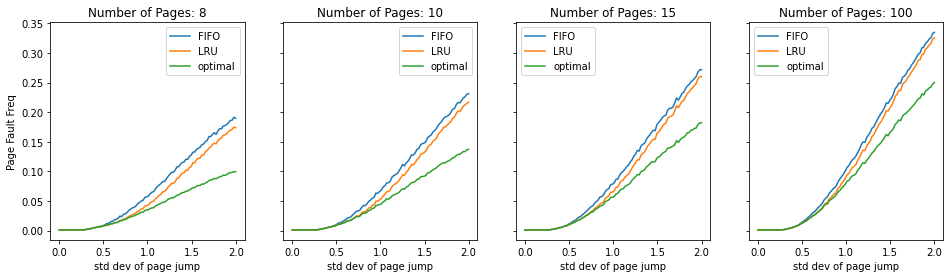

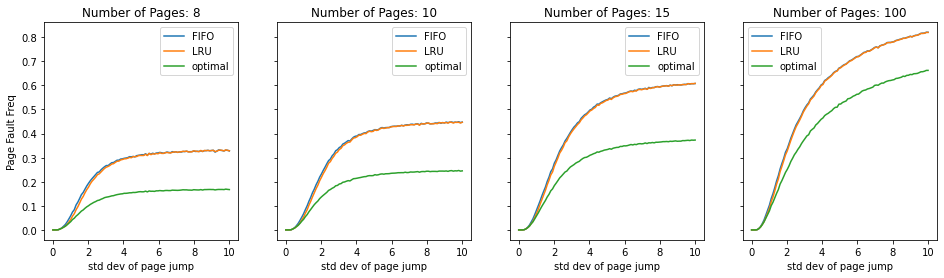

In [191]:
import numpy as np
import matplotlib.pyplot as plt


def plot_faults(max_sigma):

    sigma = np.linspace(0, max_sigma, 100)

    fig, axes = plt.subplots(1, 4, sharey=True, figsize = (16, 4))

    num_pages = [8, 10, 15, 100]

    for i in range(4):

        FIFO_faults = []
        LRU_faults = []
        opt_faults = []

        for j in range(sigma.size):

            FIFO_f = 0
            LRU_f = 0
            opt_f = 0

            for _ in range(100):

                ref_str = alt_refstr_loc(1000, num_pages[i], sigma[j])

                FIFO_f += FIFO_page_replacement(deepcopy(ref_str))
                LRU_f += LRU_page_replacement(deepcopy(ref_str))
                opt_f += optimal_page_replacement(deepcopy(ref_str))

            FIFO_faults.append(FIFO_f/100000)
            LRU_faults.append(LRU_f/100000)
            opt_faults.append(opt_f/100000)

        axes[i].plot(sigma, np.asarray(FIFO_faults), label = 'FIFO')
        axes[i].plot(sigma, np.asarray(LRU_faults), label = 'LRU')
        axes[i].plot(sigma, np.asarray(opt_faults), label = 'optimal')

        axes[i].set_title('Number of Pages: ' + str(num_pages[i]))

        axes[i].set_xlabel('std dev of page jump')

        axes[i].legend()

    axes[0].set_ylabel('Page Fault Freq')

    

    plt.savefig('page_faults_s' + str(max_sigma) + '.png', dpi = 300)

    plt.show()

plot_faults(2)

plot_faults(10)


With alternate page generation the next page request is the previous page plus a random value from a gaussian with mean = 0 and a variable standard deviation σ. Low σ results in closely clustered requests, as σ -> ∞ requests become totally random.

The plots show that FIFO (blue) performs the worst as expected, LRU (orange) is slightly better. This is most visible on the plot where 0<σ<2, because FIFO and LRU asymptotically approach the same value. Optimal (green) is the best, as σ gets large it asymptotically approaches a smaller value. These values depend on the number of pages.

### Determine the effect of locality on each algorithm

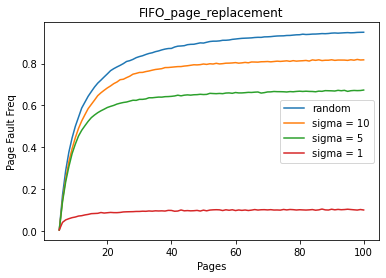

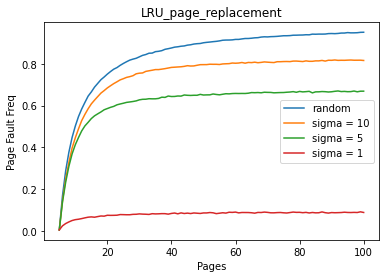

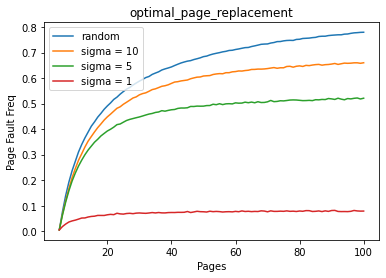

In [187]:
def test_locality(Alg):

    loc_data_s1 = []
    loc_data_s5 = []
    loc_data_s10 = []
    nonloc_data = []

    pages = np.arange(5, 101, 1)

    for i in range(pages.size):

        loc_pfaults_s1 = 0
        loc_pfaults_s5 = 0
        loc_pfaults_s10 = 0
        nonloc_pfaults = 0  

        for _ in range(100):

            loc_refstr_s1 = alt_refstr_loc(1000, pages[i])
            loc_refstr_s5 = alt_refstr_loc(1000, pages[i], 5)
            loc_refstr_s10 = alt_refstr_loc(1000, pages[i], 10)
            nonloc_refstr = alt_refstr_nonloc(1000, pages[i])

            loc_pfaults_s1 += Alg(loc_refstr_s1)
            loc_pfaults_s5 += Alg(loc_refstr_s5)
            loc_pfaults_s10 += Alg(loc_refstr_s10)
            nonloc_pfaults  += Alg(nonloc_refstr)

        loc_data_s1.append(loc_pfaults_s1/100000)
        loc_data_s5.append(loc_pfaults_s5/100000)
        loc_data_s10.append(loc_pfaults_s10/100000)
        nonloc_data.append(nonloc_pfaults/100000)

    plt.plot(pages, np.asarray(nonloc_data), label = 'random')
    plt.plot(pages, np.asarray(loc_data_s10), label = 'sigma = 10')
    plt.plot(pages, np.asarray(loc_data_s5), label = 'sigma = 5')
    plt.plot(pages, np.asarray(loc_data_s1), label = 'sigma = 1')

    plt.title(str(Alg).split(' ')[1])
    plt.xlabel('Pages')
    plt.ylabel('Page Fault Freq')

    plt.legend()

    plt.savefig(str(Alg).split(' ')[1] + '.png', dpi = 300)

    plt.show()

test_locality(FIFO_page_replacement)
test_locality(LRU_page_replacement)
test_locality(optimal_page_replacement)